## Resolución del Problema Inverso, estimar $k_0$ y $k_1$
#### Modelo farmacocinético tricompartimental


In [ ]:
#importamos librerías
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [ ]:
#Definiendo el sistemas de ecuaciones diferenciales
def ode_model(t,y):
  A, B, E = y
  dA_dt = -k0*A #tasa absorción
  dB_dt = k0*A - k1*B #tasa de cambio
  dE_dt = k1*B #tasa de eliminación
  return [dA_dt, dB_dt, dE_dt]

In [ ]:
# Asignando el valor de los diferentes parámetros
A0 = 1 #monodosis
B0 = 0 #no hay concentración en t=0
E0 = 0 #no se elimina nada en t=0
T_max = 600 #minutos
yinit = [A0,B0,E0]

#valores hallados experimentalmente
k0 = 0.01
k1 = 0.035

#generando la variable independiente t
t_span = (0, 600)  # Desde t=0 hasta t=500 min
t_eval = np.linspace(0, 600, 200)  # Puntos donde evaluar la solución

In [ ]:
sol = solve_ivp(ode_model, t_span, yinit, t_eval=t_eval, method="RK45")
t_np = sol.t
A_np, B_np, E_np = sol.y

#Convertimos a tensores
t_all = torch.tensor(t_np, dtype=torch.float32).view(-1, 1)
A_all = torch.tensor(A_np, dtype=torch.float32).view(-1, 1)
B_all = torch.tensor(B_np, dtype=torch.float32).view(-1, 1)
E_all = torch.tensor(E_np, dtype=torch.float32).view(-1, 1)


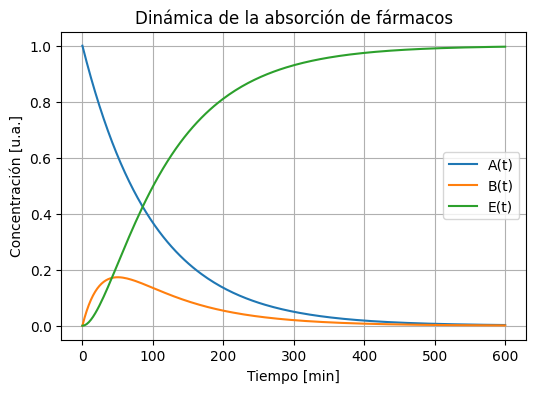

In [ ]:
#Representando las soluciones del sistema de ecuaciones diferenciales
fig = plt.figure(figsize=(6, 4))
plt.plot(sol.t, sol.y[0], label="A(t)")
plt.plot(sol.t, sol.y[1], label="B(t)")
plt.plot(sol.t, sol.y[2], label="E(t)")
plt.xlabel('Tiempo [min]')
plt.ylabel('Concentración [u.a.]')
plt.legend()
plt.title('Dinámica de la absorción de fármacos')
plt.grid()

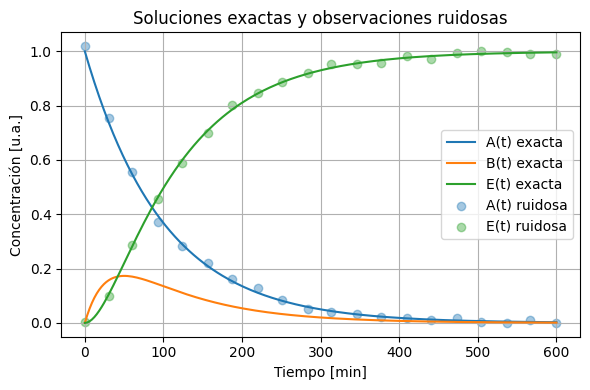

In [ ]:
# Datos observacionales ruidosos
torch.manual_seed(42)

# Número de muestras equiespaciadas
n_obs = 20

# Índices equiespaciados desde 0 hasta el último índice
idx_obs = torch.linspace(0, t_all.shape[0] - 1, steps=n_obs).long()

t_obs = t_all[idx_obs]  # Tiempos observacionales

# Extraemos los valores exactos de A, B y E en esos tiempos
A_obs = A_all[idx_obs]
B_obs = B_all[idx_obs]
E_obs = E_all[idx_obs]

# Añadimos ruido gaussiano (media 0, desviación 0.04)
A_obs_r = torch.clamp(A_obs + 0.01 * torch.randn_like(A_obs), min = 0.0)
E_obs_r = torch.clamp(E_obs + 0.01 * torch.randn_like(E_obs), min = 0.0)

#visualización
plt.figure(figsize=(6, 4))
plt.plot(t_all, A_all, label="A(t) exacta")
plt.plot(t_all, B_all, label="B(t) exacta")
plt.plot(t_all, E_all, label="E(t) exacta")
plt.scatter(t_obs, A_obs_r, label="A(t) ruidosa", alpha=0.4)
plt.scatter(t_obs, E_obs_r, label="E(t) ruidosa", alpha=0.4, color = "tab:green")
plt.xlabel("Tiempo [min]")
plt.ylabel("Concentración [u.a.]")
plt.title("Soluciones exactas y observaciones ruidosas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Red neuronal
class FCN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, layers):
        super().__init__()
        activation = nn.Tanh
        self.input_layer = nn.Sequential(nn.Linear(in_dim, hidden_dim), activation())
        self.hidden_layers = nn.Sequential(*[
            nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation()) for _ in range(layers - 1)
        ])
        self.output_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layers(x)
        return self.output_layer(x)

Paso 0: Total = 0.584273 | BC = 0.488561 | Física = 0.000197 | Observaciones = 0.955146 | K0 = -0.001000, | k1 = 0.000999


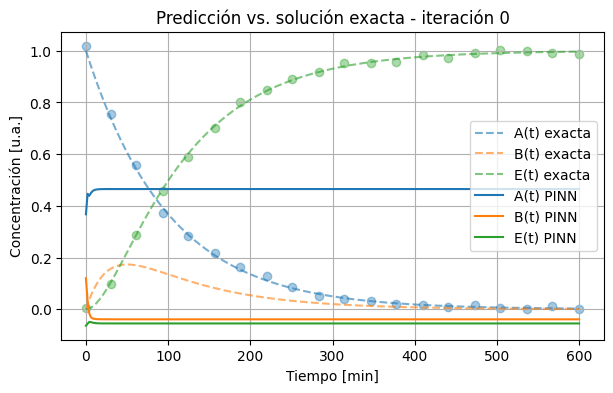

Paso 1000: Total = 0.000031 | BC = 0.000000 | Física = 0.000004 | Observaciones = 0.000271 | K0 = 0.007584, | k1 = 0.058681
Paso 2000: Total = 0.000017 | BC = 0.000000 | Física = 0.000002 | Observaciones = 0.000153 | K0 = 0.008328, | k1 = 0.059481
Paso 3000: Total = 0.000015 | BC = 0.000000 | Física = 0.000001 | Observaciones = 0.000142 | K0 = 0.008574, | k1 = 0.063992
Paso 4000: Total = 0.000014 | BC = 0.000000 | Física = 0.000001 | Observaciones = 0.000133 | K0 = 0.008721, | k1 = 0.066768
Paso 5000: Total = 0.000031 | BC = 0.000015 | Física = 0.000000 | Observaciones = 0.000149 | K0 = 0.008909, | k1 = 0.069950


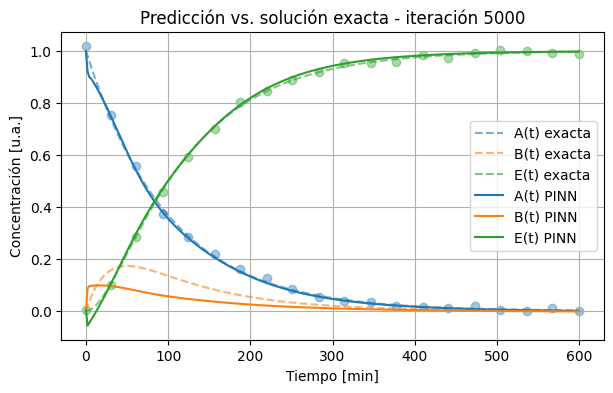

Paso 6000: Total = 0.000013 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000121 | K0 = 0.008993, | k1 = 0.067523
Paso 7000: Total = 0.000014 | BC = 0.000002 | Física = 0.000000 | Observaciones = 0.000123 | K0 = 0.009166, | k1 = 0.065070
Paso 8000: Total = 0.000012 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000114 | K0 = 0.009204, | k1 = 0.062192
Paso 9000: Total = 0.000012 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000113 | K0 = 0.009255, | k1 = 0.058954
Paso 10000: Total = 0.000015 | BC = 0.000002 | Física = 0.000000 | Observaciones = 0.000121 | K0 = 0.009251, | k1 = 0.054820


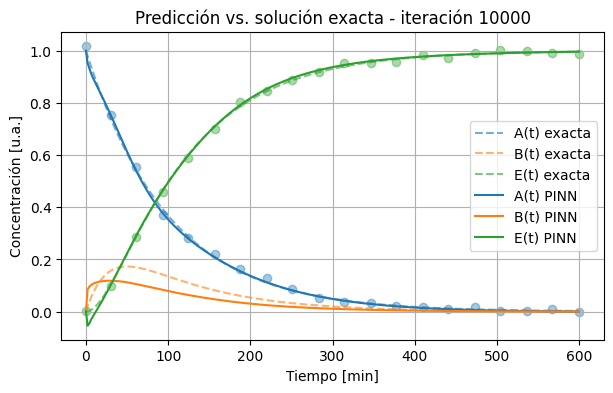

Paso 11000: Total = 0.000012 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000117 | K0 = 0.009345, | k1 = 0.051739
Paso 12000: Total = 0.000011 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000108 | K0 = 0.009376, | k1 = 0.049761
Paso 13000: Total = 0.000011 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000107 | K0 = 0.009749, | k1 = 0.048096
Paso 14000: Total = 0.000011 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000108 | K0 = 0.009761, | k1 = 0.045687
Paso 15000: Total = 0.000011 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000104 | K0 = 0.009758, | k1 = 0.045303


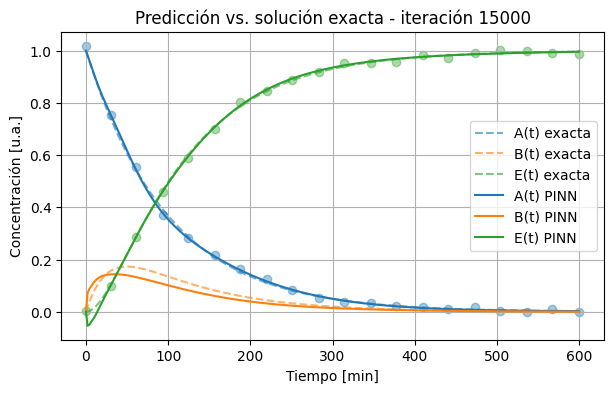

Paso 16000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000101 | K0 = 0.009758, | k1 = 0.043975
Paso 17000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000099 | K0 = 0.009750, | k1 = 0.041566
Paso 18000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000095 | K0 = 0.009711, | k1 = 0.040165
Paso 19000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000095 | K0 = 0.009716, | k1 = 0.039167
Paso 20000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000094 | K0 = 0.009716, | k1 = 0.038302


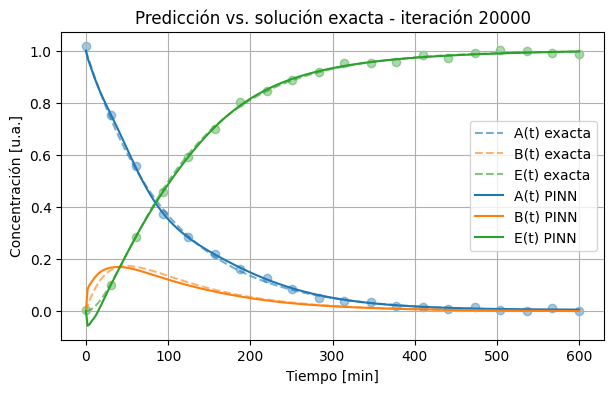

Paso 21000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000091 | K0 = 0.009712, | k1 = 0.037549
Paso 22000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000092 | K0 = 0.009709, | k1 = 0.036901
Paso 23000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000093 | K0 = 0.009696, | k1 = 0.036485
Paso 24000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000095 | K0 = 0.009751, | k1 = 0.036132
Paso 25000: Total = 0.000016 | BC = 0.000004 | Física = 0.000000 | Observaciones = 0.000122 | K0 = 0.009685, | k1 = 0.035605


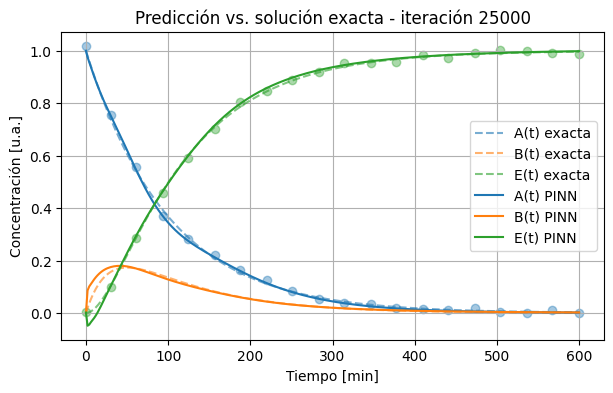

Paso 26000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000094 | K0 = 0.009748, | k1 = 0.035497
Paso 27000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000093 | K0 = 0.009751, | k1 = 0.035662
Paso 28000: Total = 0.000014 | BC = 0.000005 | Física = 0.000000 | Observaciones = 0.000096 | K0 = 0.009724, | k1 = 0.035217
Paso 29000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000090 | K0 = 0.009798, | k1 = 0.035022
Paso 30000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.009812, | k1 = 0.034839


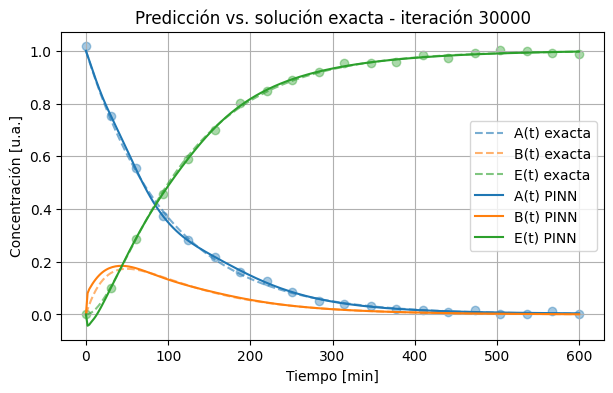

Paso 31000: Total = 0.000013 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000116 | K0 = 0.009882, | k1 = 0.035102
Paso 32000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000092 | K0 = 0.009816, | k1 = 0.034549
Paso 33000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000092 | K0 = 0.009859, | k1 = 0.034519
Paso 34000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000095 | K0 = 0.009891, | k1 = 0.034528
Paso 35000: Total = 0.000012 | BC = 0.000003 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.009868, | k1 = 0.034681


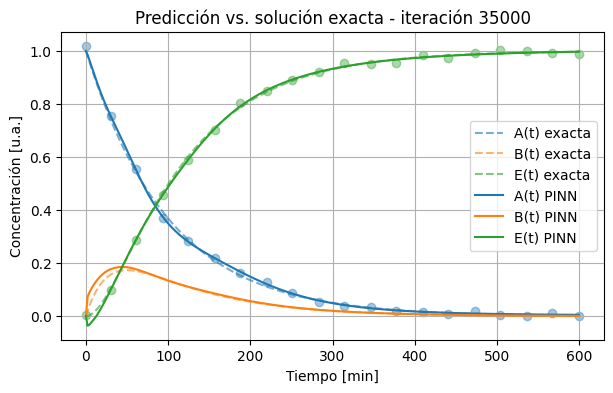

Paso 36000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.009847, | k1 = 0.035166
Paso 37000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000090 | K0 = 0.009891, | k1 = 0.034684
Paso 38000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.009911, | k1 = 0.034962
Paso 39000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000090 | K0 = 0.009932, | k1 = 0.035246
Paso 40000: Total = 0.000016 | BC = 0.000005 | Física = 0.000000 | Observaciones = 0.000106 | K0 = 0.009923, | k1 = 0.035249


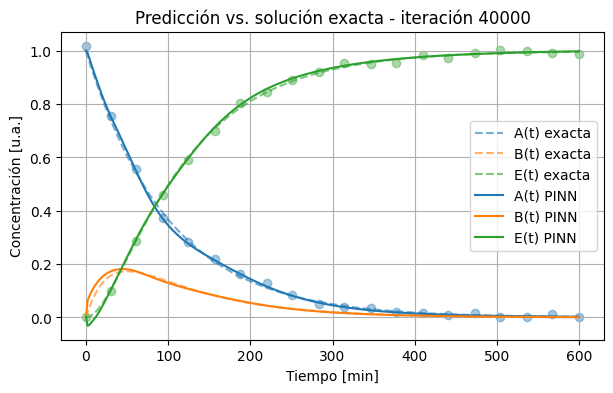

Paso 41000: Total = 0.000012 | BC = 0.000002 | Física = 0.000000 | Observaciones = 0.000094 | K0 = 0.009991, | k1 = 0.035449
Paso 42000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.009948, | k1 = 0.035570
Paso 43000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.009968, | k1 = 0.035931
Paso 44000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.009976, | k1 = 0.035979
Paso 45000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.009990, | k1 = 0.035573


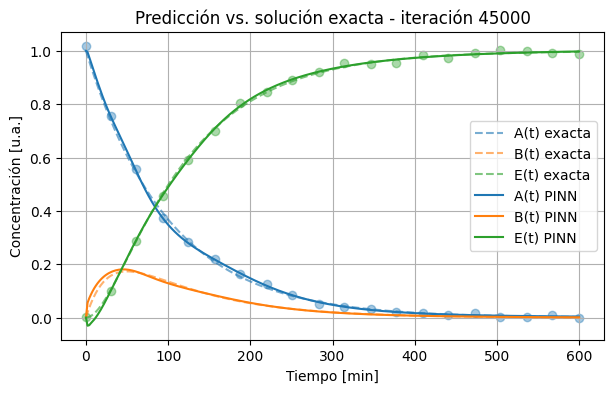

Paso 46000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010006, | k1 = 0.035638
Paso 47000: Total = 0.000012 | BC = 0.000002 | Física = 0.000000 | Observaciones = 0.000100 | K0 = 0.009919, | k1 = 0.035368
Paso 48000: Total = 0.000012 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000099 | K0 = 0.010047, | k1 = 0.035988
Paso 49000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000093 | K0 = 0.010048, | k1 = 0.035923
Paso 50000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.010017, | k1 = 0.035872


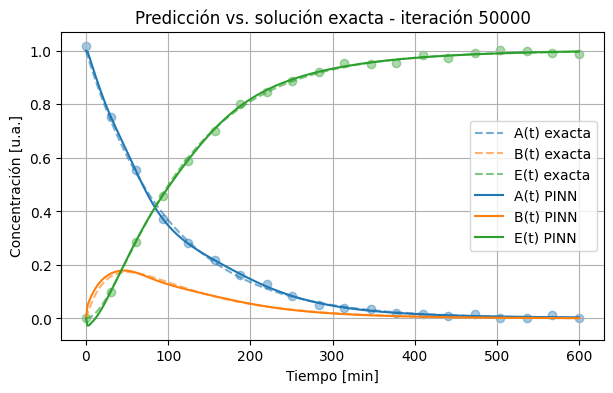

Paso 51000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000090 | K0 = 0.010033, | k1 = 0.036049
Paso 52000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010039, | k1 = 0.035844
Paso 53000: Total = 0.000010 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000092 | K0 = 0.010042, | k1 = 0.036183
Paso 54000: Total = 0.000011 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000094 | K0 = 0.009997, | k1 = 0.036407
Paso 55000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000089 | K0 = 0.010053, | k1 = 0.036192


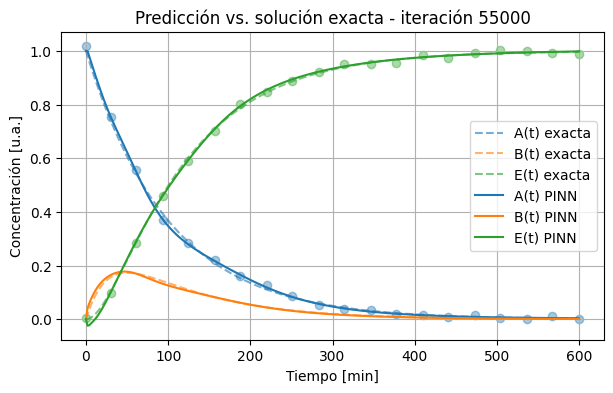

Paso 56000: Total = 0.000010 | BC = 0.000001 | Física = 0.000000 | Observaciones = 0.000092 | K0 = 0.010037, | k1 = 0.036317
Paso 57000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010068, | k1 = 0.036442
Paso 58000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010065, | k1 = 0.036711
Paso 59000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010076, | k1 = 0.036900
Paso 60000: Total = 0.000009 | BC = 0.000000 | Física = 0.000000 | Observaciones = 0.000088 | K0 = 0.010069, | k1 = 0.036570


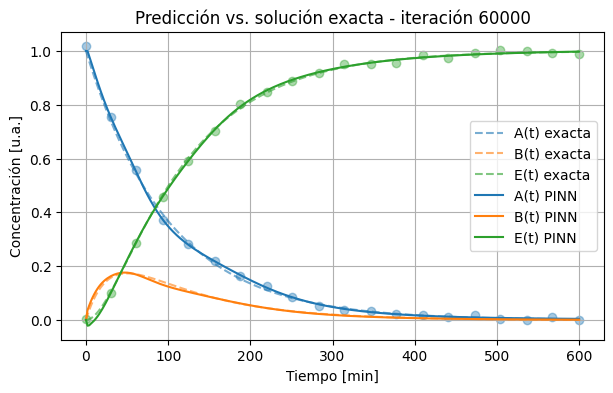

In [ ]:
pinn = FCN(1, 3, 32, 3)  # 1 entrada (tiempo), 3 salidas (A, B, E)
k0 = torch.nn.Parameter(torch.tensor([0.0], requires_grad=True))
k0s = []
k1 = torch.nn.Parameter(torch.tensor([0.0], requires_grad=True))
k1s = []

optimizer = torch.optim.Adam(list(pinn.parameters()) + [k0, k1], lr=1e-3)

# Ponderaciones de pérdida
lambda_bc = 1
lambda_phys = 1
lambda_obs = 1e-1

T_max = 600  # tiempo máximo sin normalizar
t_boundary = torch.tensor([[0.0]], requires_grad=True)           # condición inicial en t=0
t_physics = torch.linspace(0, T_max, 200).view(-1, 1).requires_grad_(True)  # tiempo real sin normalizar
t_test = torch.linspace(0, T_max, 100).view(-1, 1)
t_obs = t_obs.requires_grad_(True)

# Observaciones ya definidas en variable t_obs, A_obs_r, B_obs_r, E_obs_r (sin normalizar)
loss_total_list, loss_bc_list, loss_phys_list, loss_obs_list = [], [], [], []

A_sol, B_sol, E_sol = sol.y

for i in range(60001):
    optimizer.zero_grad()

    # Condiciones iniciales (t=0)
    pred_boundary = pinn(t_boundary)
    A0_pred, B0_pred, E0_pred = pred_boundary[0]
    loss_bc = (A0_pred - A0)**2 + (B0_pred - B0)**2 + (E0_pred - E0)**2

    # Predicciones para condiciones físicas
    pred_physics = pinn(t_physics)
    A_pred = pred_physics[:, 0:1]
    B_pred = pred_physics[:, 1:2]
    E_pred = pred_physics[:, 2:3]

    # Derivadas respecto al tiempo (real)
    dA_dt = torch.autograd.grad(A_pred, t_physics, torch.ones_like(A_pred), create_graph=True)[0]
    dB_dt = torch.autograd.grad(B_pred, t_physics, torch.ones_like(B_pred), create_graph=True)[0]
    dE_dt = torch.autograd.grad(E_pred, t_physics, torch.ones_like(E_pred), create_graph=True)[0]

    # Pérdidas de las ODE
    loss_ode_A = dA_dt + k0 * A_pred
    loss_ode_B = dB_dt - (k0 * A_pred - k1 * B_pred)
    loss_ode_E = dE_dt - (k1 * B_pred)

    loss_phys = torch.mean(loss_ode_A**2) + torch.mean(loss_ode_B**2) + torch.mean(loss_ode_E**2)

    # Predicción en observaciones
    pred_obs = pinn(t_obs)
    A_pred_obs = pred_obs[:, 0:1]
    #B_pred_obs = pred_obs[:, 1:2]
    E_pred_obs = pred_obs[:, 2:3]

    loss_obs = torch.mean((A_pred_obs - A_obs_r)**2) + torch.mean((E_pred_obs - E_obs_r)**2)

    # Pérdida total
    loss = lambda_bc * loss_bc + lambda_phys * loss_phys + lambda_obs * loss_obs
    loss.backward()
    optimizer.step()

    loss_total_list.append(loss.item())
    loss_bc_list.append(loss_bc.item())
    loss_phys_list.append(loss_phys.item())
    loss_obs_list.append(loss_obs.item())
    k0s.append(k0.item())
    k1s.append(k1.item())

    if i % 1000 == 0:
        print(f"Paso {i}: Total = {loss.item():.6f} | BC = {loss_bc.item():.6f} | Física = {loss_phys.item():.6f} | Observaciones = {loss_obs.item():.6f} | K0 = {k0.item():.6f}, | k1 = {k1.item():.6f}")

    if i % 5000 == 0:
        with torch.no_grad():
            t_test = torch.linspace(0, T_max, 300).view(-1, 1)
            pred_test = pinn(t_test)
            A_pred_test = pred_test[:, 0].numpy()
            B_pred_test = pred_test[:, 1].numpy()
            E_pred_test = pred_test[:, 2].numpy()

            plt.figure(figsize=(7,4))
            plt.plot(t_np, A_np, '--', color ='tab:blue', label='A(t) exacta', alpha=0.6)
            plt.plot(t_np, B_np,  '--', color ='tab:orange', label='B(t) exacta', alpha=0.6)
            plt.plot(t_np, E_np, '--', color ='tab:green', label='E(t) exacta', alpha=0.6)
            plt.plot(t_test.numpy(), A_pred_test, color = 'tab:blue', label='A(t) PINN')
            plt.plot(t_test.numpy(), B_pred_test, color='tab:orange', label='B(t) PINN')
            plt.plot(t_test.numpy(), E_pred_test, color='tab:green' , label='E(t) PINN')
            plt.scatter(t_obs.numpy(), A_obs_r.numpy(), color='tab:blue', alpha=0.4)
            #plt.scatter(t_obs.numpy(), B_obs_r.numpy(), color='tab:orange', alpha=0.4)
            plt.scatter(t_obs.numpy(), E_obs_r.numpy(), color='tab:green', alpha=0.4)
            plt.xlabel("Tiempo [min]")
            plt.ylabel("Concentración [u.a.]")
            plt.title(f"Predicción vs. solución exacta - iteración {i}")
            plt.legend(loc='center right')
            plt.grid(True)
            plt.show()


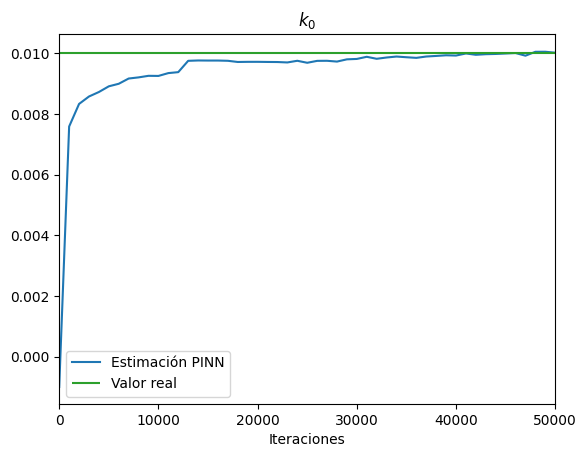

In [ ]:
pasos = np.arange(len(k0s))
pasos_filtrados = pasos[::1000]
k0s_filtrados = k0s[::1000]

plt.figure()
plt.title(r"$k_0$")
plt.plot(pasos_filtrados, k0s_filtrados, label="Estimación PINN")
plt.hlines(0.01, pasos_filtrados[0], pasos_filtrados[-1], label="Valor real", color="tab:green")
plt.legend()
plt.xlabel("Iteraciones")
plt.xlim(0,50000)
plt.show()

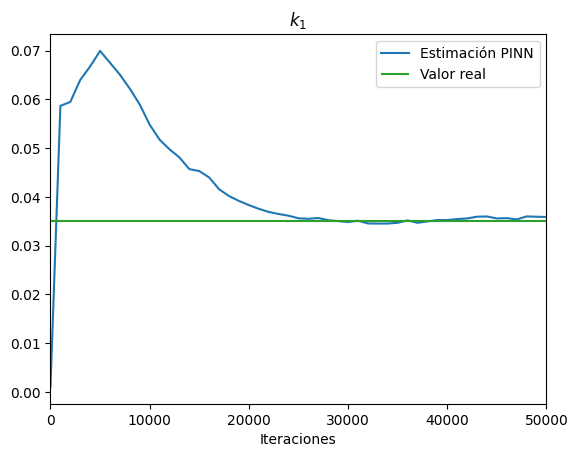

In [ ]:
pasos = np.arange(len(k1s))
pasos_filtrados = pasos[::1000]
k1s_filtrados = k1s[::1000]

plt.figure()
plt.title(r"$k_1$")
plt.plot(pasos_filtrados, k1s_filtrados, label="Estimación PINN")
plt.hlines(0.035, pasos_filtrados[0], pasos_filtrados[-1], label="Valor real", color="tab:green")
plt.legend()
plt.xlim(0,50000)
#plt.ylim(-0.01, 0.03)
plt.xlabel("Iteraciones")
plt.show()

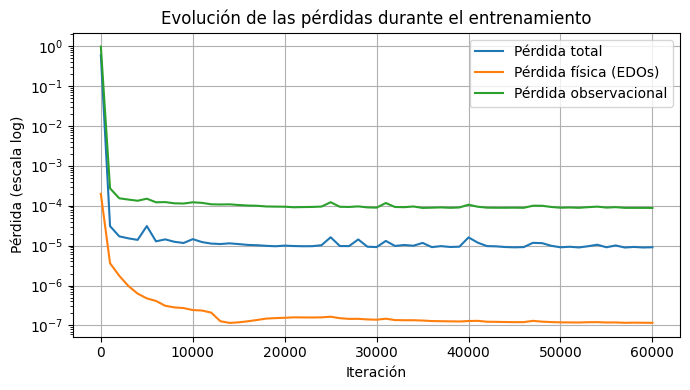

In [ ]:
# Índices de iteración cada 1000 pasos
iters = list(range(0, len(loss_total_list), 1000))

# Submuestreo de las listas
loss_total_sub = loss_total_list[::1000]
loss_bc_sub = loss_bc_list[::1000]
loss_phys_sub = loss_phys_list[::1000]
loss_obs_sub = loss_obs_list[::1000]

# Gráfica de pérdidas
plt.figure(figsize=(7, 4))
plt.plot(iters, loss_total_sub, label='Pérdida total')
#plt.plot(iters,loss_bc_sub, label='Pérdida condiciones iniciales (BC)')
plt.plot(iters,loss_phys_sub, label='Pérdida física (EDOs)')
plt.plot(iters,loss_obs_sub, label='Pérdida observacional')
plt.yscale('log')
plt.xlabel('Iteración')
plt.ylabel('Pérdida (escala log)')
plt.title('Evolución de las pérdidas durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()